# AR/MA processes as as state-space models

In [1]:
import jax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

/var/folders/vf/3b13gs616172kztlr53t6_s00000gn/T/ipykernel_35764/41963291.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

sns.set_palette("colorblind")

In [3]:
def step(x, key, F, H, T):
    et = jax.random.normal(key, (1,1)) * w0
    y = H @ x + et # y(t)
    z = F @ x + T @ et # z(t+1)

    out = {
        "y": y,
        "z": z
    }
    
    return z, out

##  MA(m) process

A time series ${\bf y}_{1:t}$ is said to be a $m$-th order moving average (MA) process
if there are known $p\times p$ matrices ${\bf A}_1, \ldots, {\bf A}_m$ such that
$$
    y_t = \sum_{j=1}^m {\bf A}_{t-j}\,e_j + e_t
$$

In state-space form, the AR(m) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm MA}\,{\bf z}_t + {\bf e}_t\\
    {\bf z}_{t+1} &= {\bf F}_{\rm MA}\,{\bf z}_t + {\bf T}_m\,{\bf e}_t
\end{aligned}
$$
with
$$
    {\bf F}_\text{AR} =
    \begin{bmatrix}
    {\bf 0} & \ldots & {\bf 0} & {\bf 0}\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and ${\bf u}_t = {\bf T}_m\,{\bf e}_t$ for ${\bf T}_m$ given by
$$
    {\bf T}_m =
    \begin{bmatrix}
    {\bf I}\\
    {\bf 0} \\
    \vdots \\
    {\bf 0}
    \end{bmatrix}
$$

### Building blocks

In [4]:
A = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0]) 
A = jnp.ones(5)[None, :]
m = len(A.squeeze())

In [5]:
Fma = jnp.r_[
    jnp.zeros((1, m-1)),
    jnp.eye(m-1)
]
Fma = jnp.c_[Fma, jnp.zeros(m)]
Fma

Array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [6]:
Tm = jnp.zeros((m,1)).at[0].set(1)
Tm

Array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

### Sampling

In [7]:
key = jax.random.PRNGKey(314)

In [8]:
n_samples = 100

In [9]:
step_ma = partial(step, F=Fma, H=A, T=Tm)

w0 = 0.1 ** 2 # measurement noise
z0 = jnp.zeros((m, 1))

keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step_ma, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

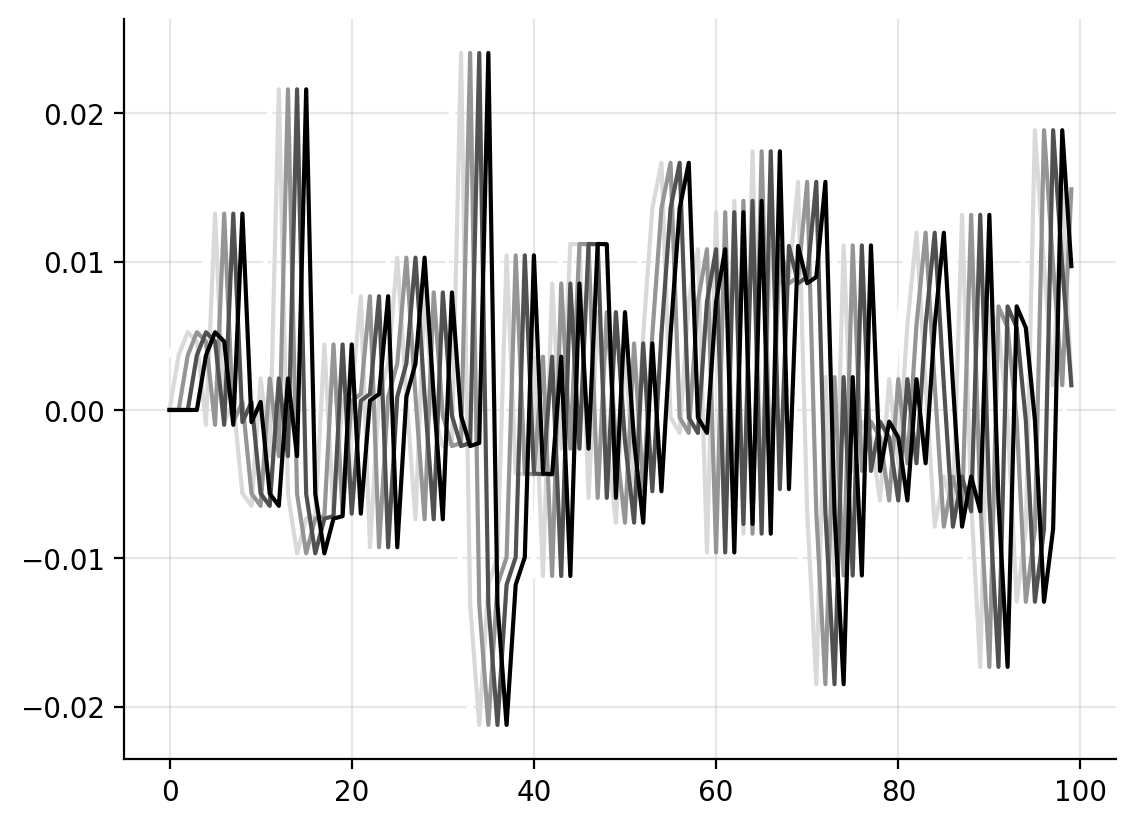

In [10]:
colors = plt.cm.Grays(jnp.linspace(0, 1, m))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

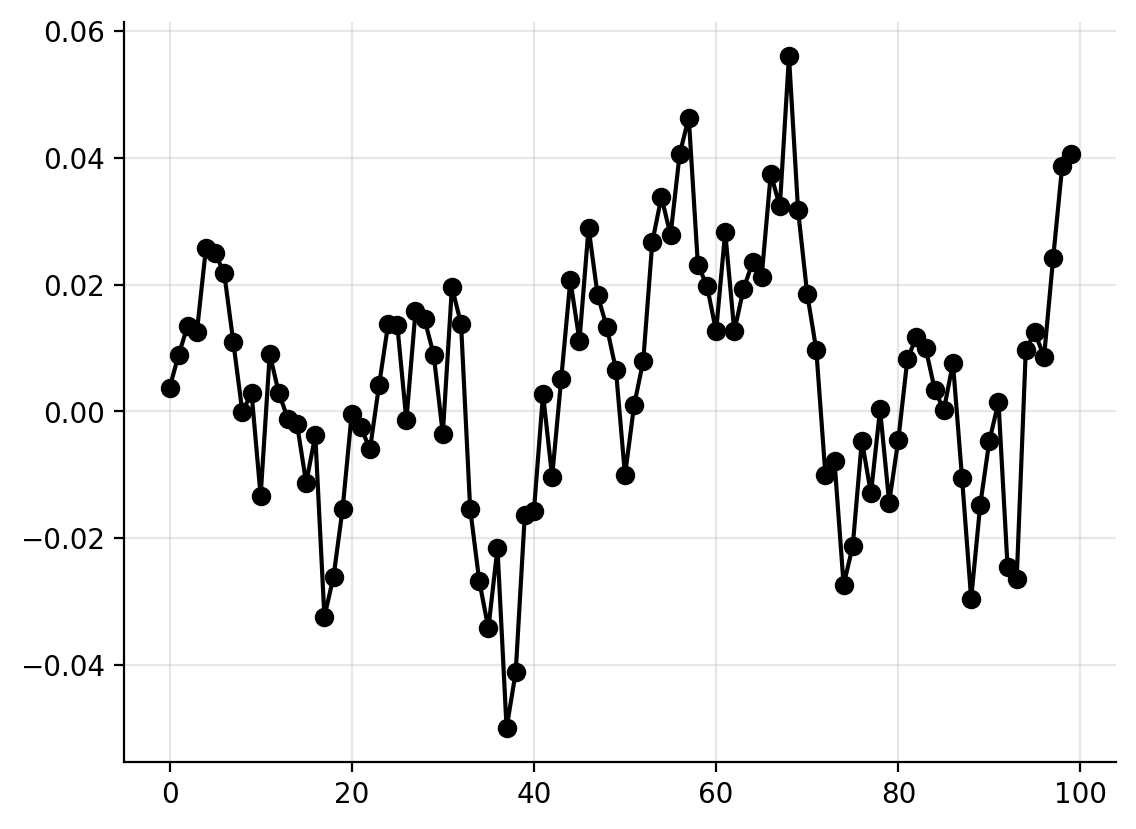

In [11]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

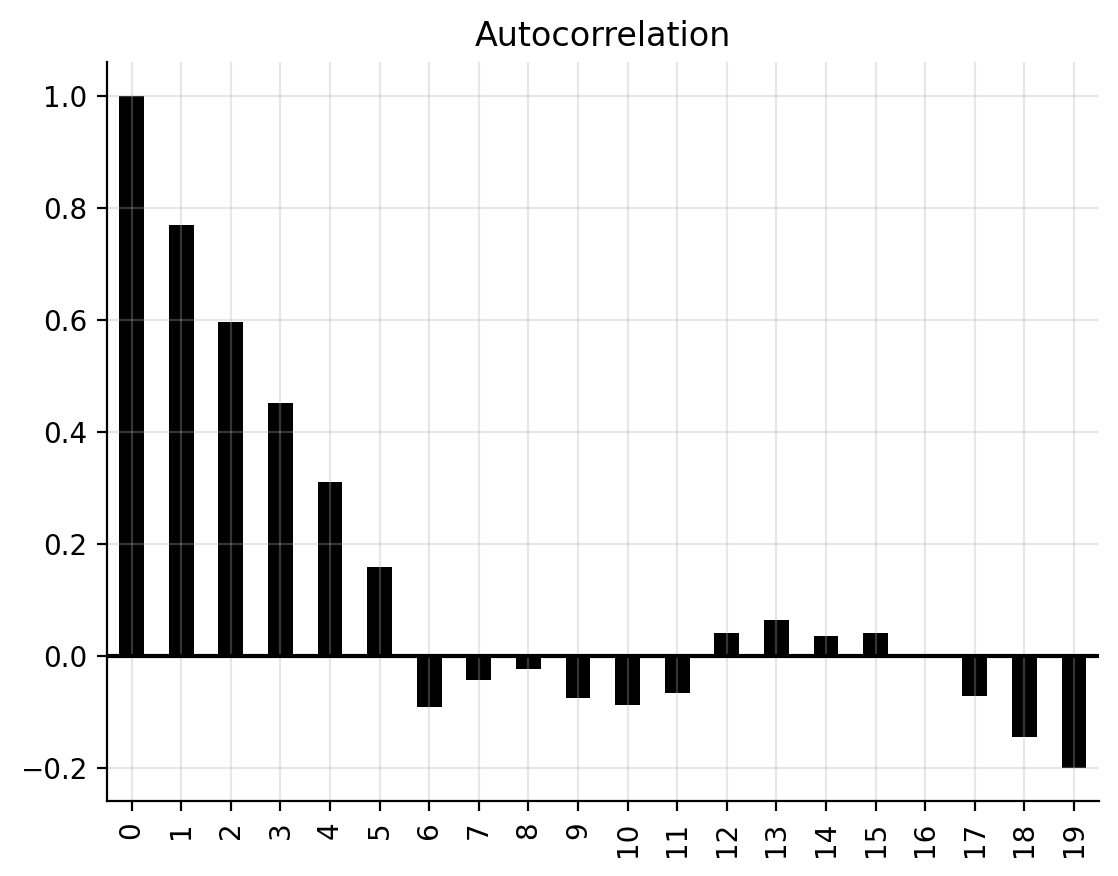

In [12]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.title("Autocorrelation")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## AR(r) process

An $r$th order autoregressive (AR) process has the form
$$
    y_t = \sum_{j=1}^r {\bf B}_j\,y_{t-j} + e_t
$$
with ${\bf B}_1, \ldots, {\bf B}_r$ known coefficient matrices, $e_{1:t}$ zero-mean blockwise uncorrelated random vectors
and $y_{-1} = \ldots = y_{-r} = 0$.

In state-space form, the MA(p) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm AR}{\bf z}_t + {\bf e}_t\\
    {\bf z}_{t+1} &= {\bf F}_{\rm AR}{\bf z}_t + {\bf T}_r\,{\bf e}_t
\end{aligned}
$$

with
$$
    {\bf F}_\text{MA} =
    \begin{bmatrix}
    {\bf B}_1 & \ldots & {\bf B}_{r-1} & {\bf B}_r\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and
$$
    {\bf H}_{\rm MA} =
    \begin{bmatrix}
    {\bf B}_1, \ldots, {\bf B}_r
    \end{bmatrix}
$$

In [13]:
n_samples = 100

B = jnp.array([[0.1, 0.2, -0.3, -0.5]])
B = jnp.array([[1.0, -1.0, 1.0, -1.0]]) 
r = len(B.ravel())

In [14]:
Far = jnp.r_[
    B,
    jnp.eye(r)
]
Far = Far[:-1, :]
Far

Array([[ 1., -1.,  1., -1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]], dtype=float32)

In [15]:
Tr = jnp.zeros((r,1)).at[0].set(1)
Tr

Array([[1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

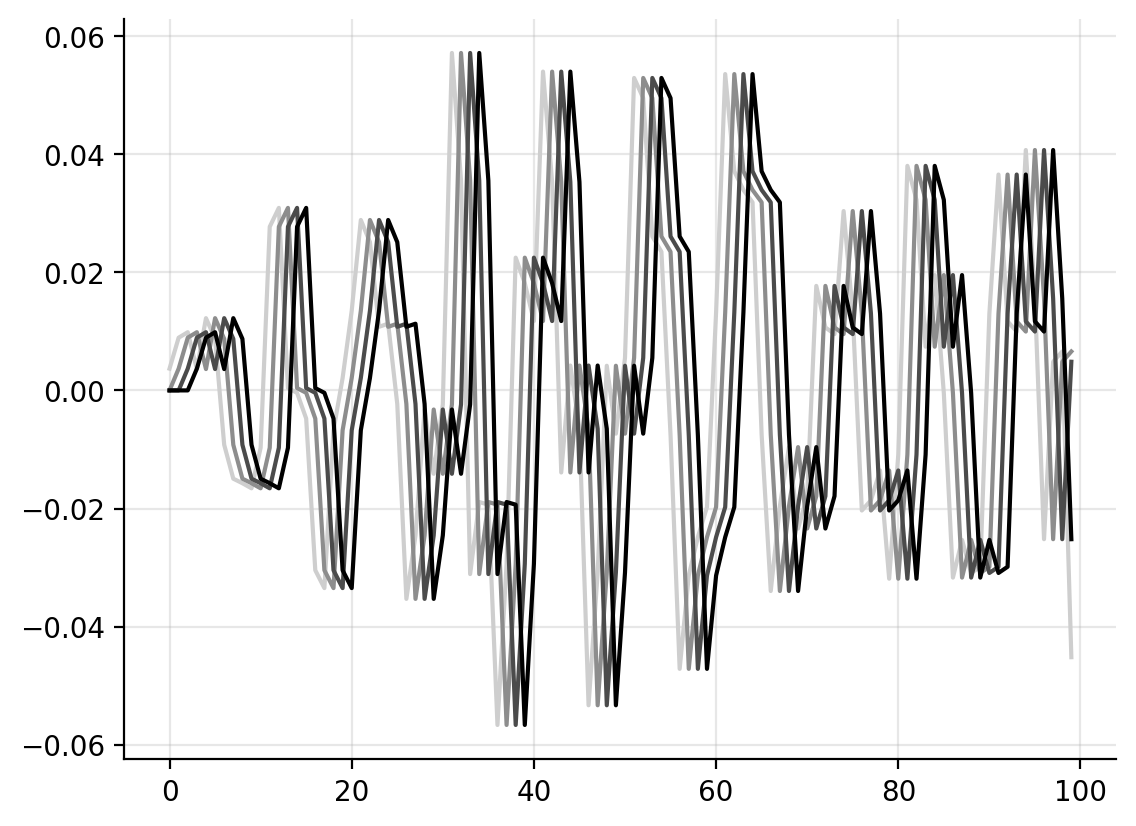

In [16]:
step_ar = partial(step, F=Far, H=B, T=Tr)

w0 = 0.1 ** 2 # measurement noise
z0 = jnp.zeros((r,1))

keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step_ar, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

colors = plt.cm.Greys(jnp.linspace(0.3, 1, r))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

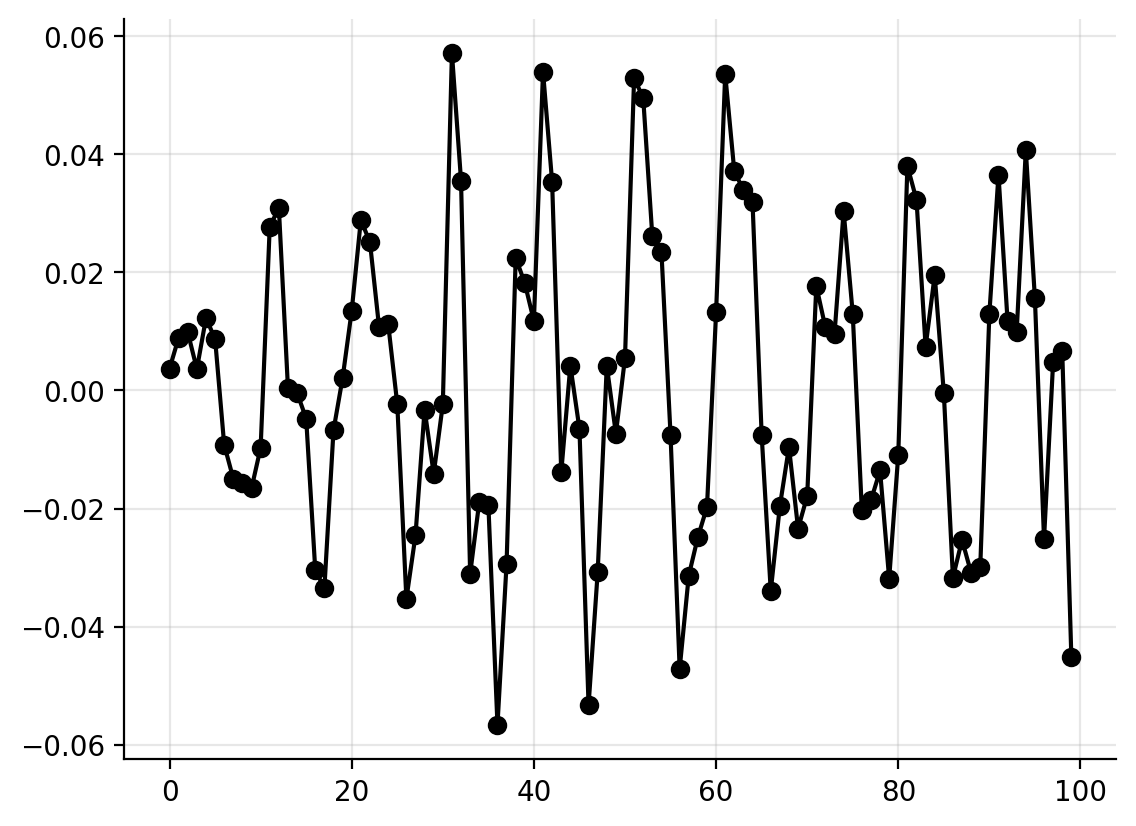

In [17]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

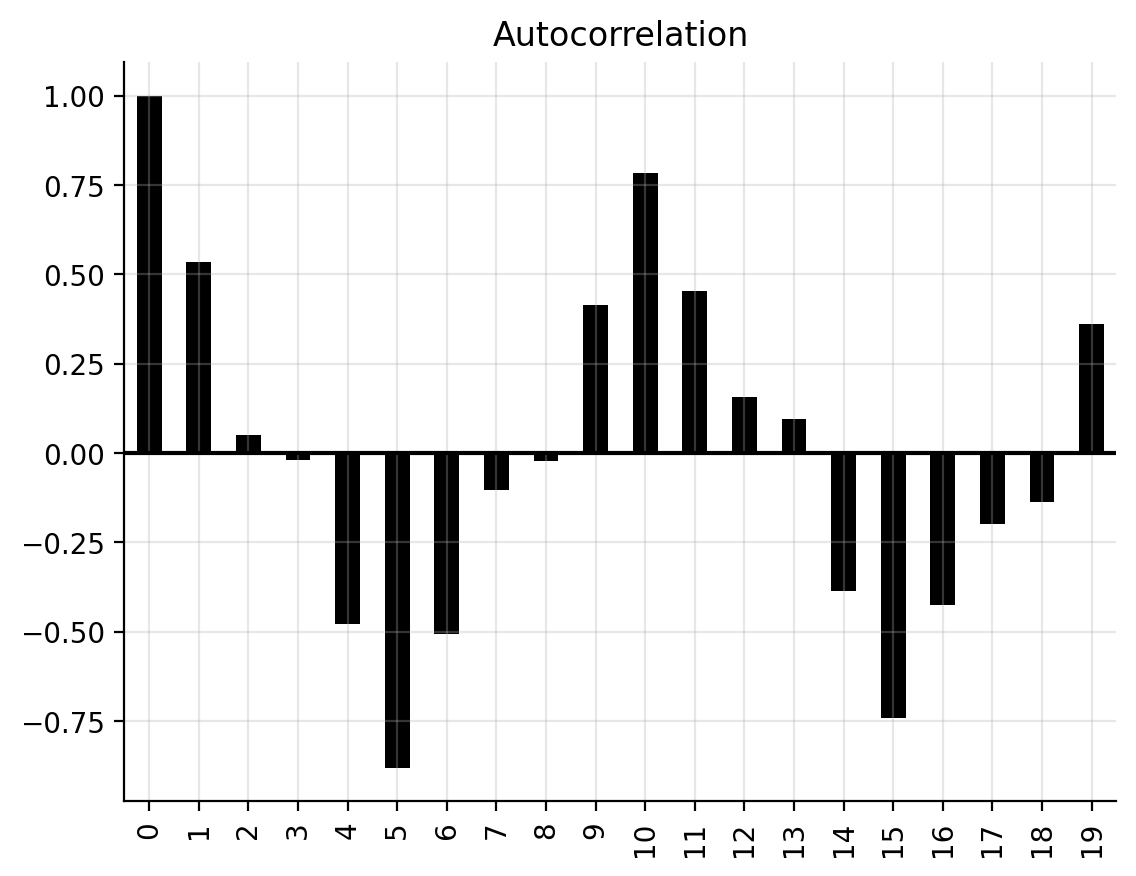

In [18]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.axhline(y=0, c="black")
plt.title("Autocorrelation")
plt.grid(alpha=0.3)

## ARMA(r,m) processs

In [19]:
Farma = jnp.zeros((r + m, r + m))
Farma = Farma.at[:r,:r].set(Far)
Farma = Farma.at[r:, r:].set(Fma)

Harma = jnp.c_[B, A]

<Axes: >

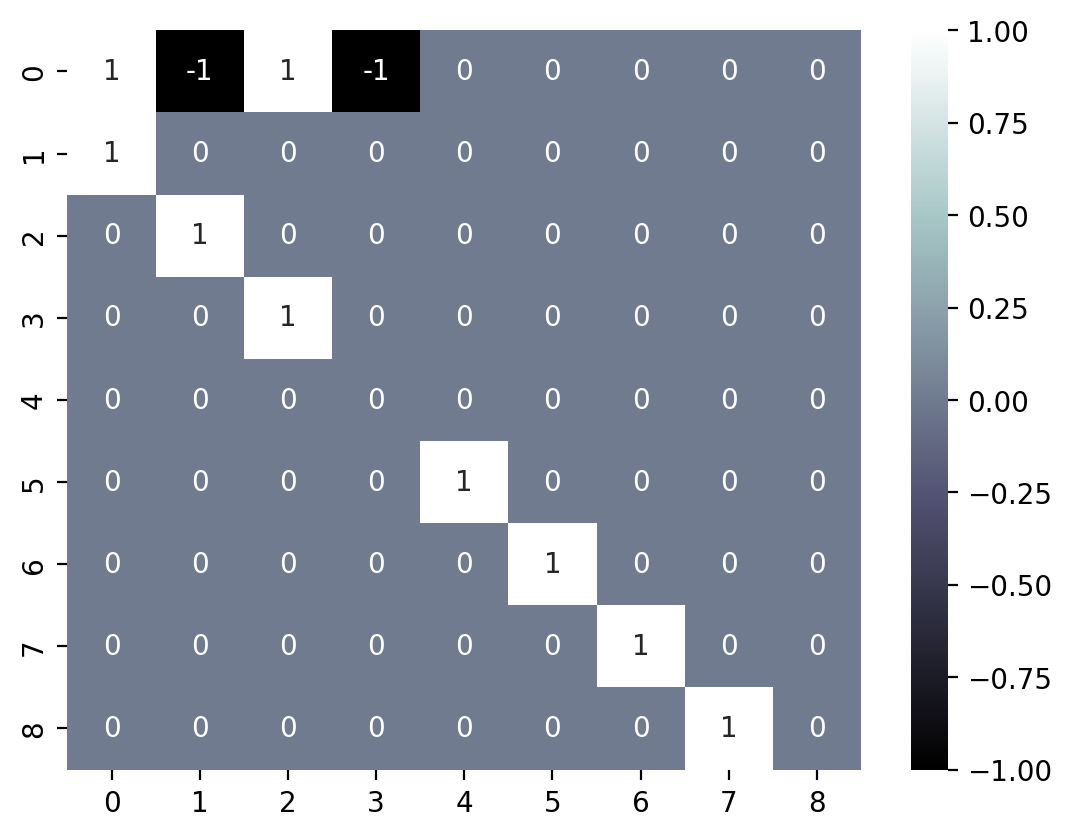

In [20]:
sns.heatmap(Farma, cmap="bone", annot=True)

In [21]:
Trm = jnp.r_[Tr, Tm]

In [22]:
step_arma = partial(step, F=Farma, H=Harma, T=Trm)

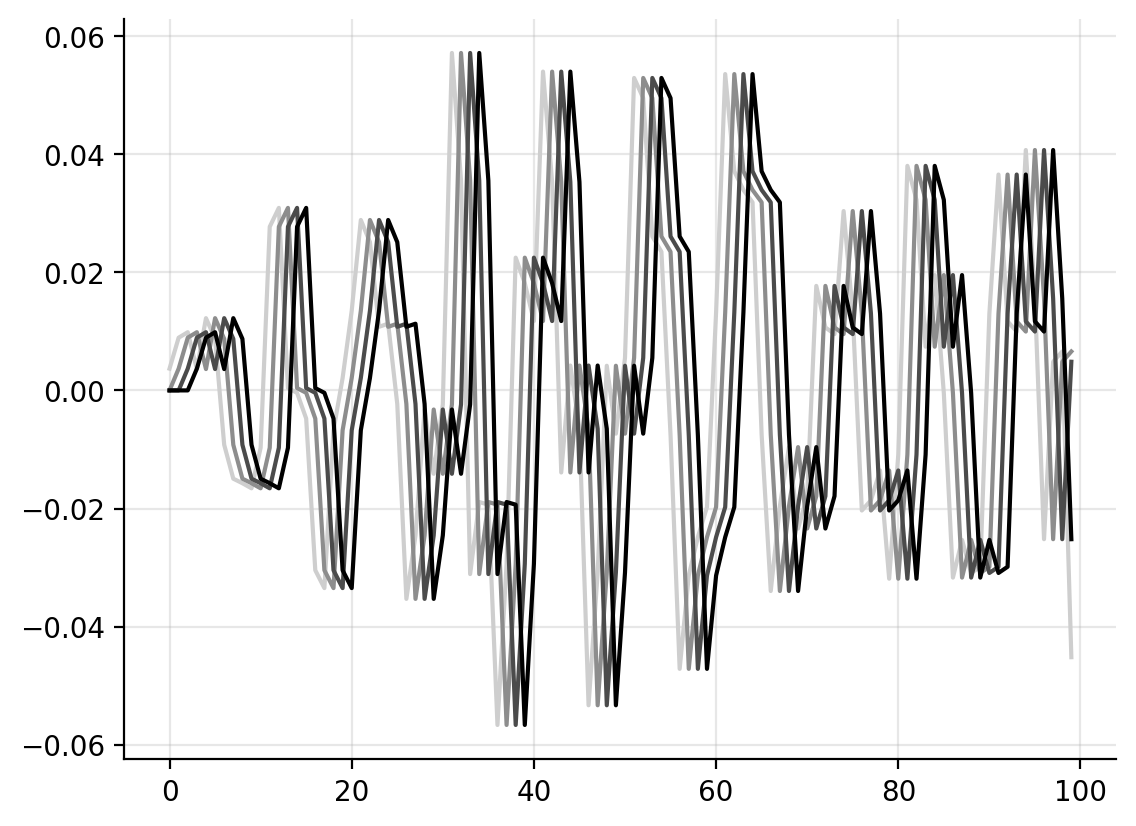

In [24]:
z0 = jnp.zeros((r + m,1))

keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step_arma, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

colors = plt.cm.Greys(jnp.linspace(0.3, 1, r))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

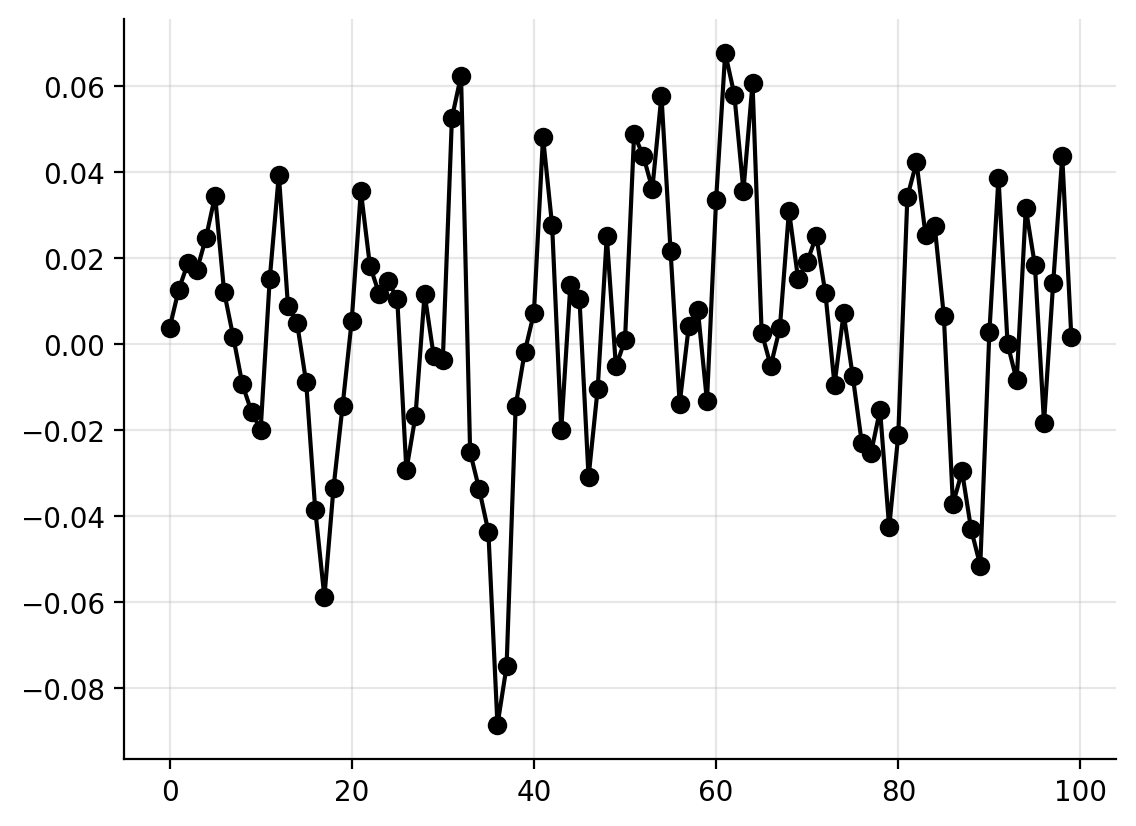

In [25]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

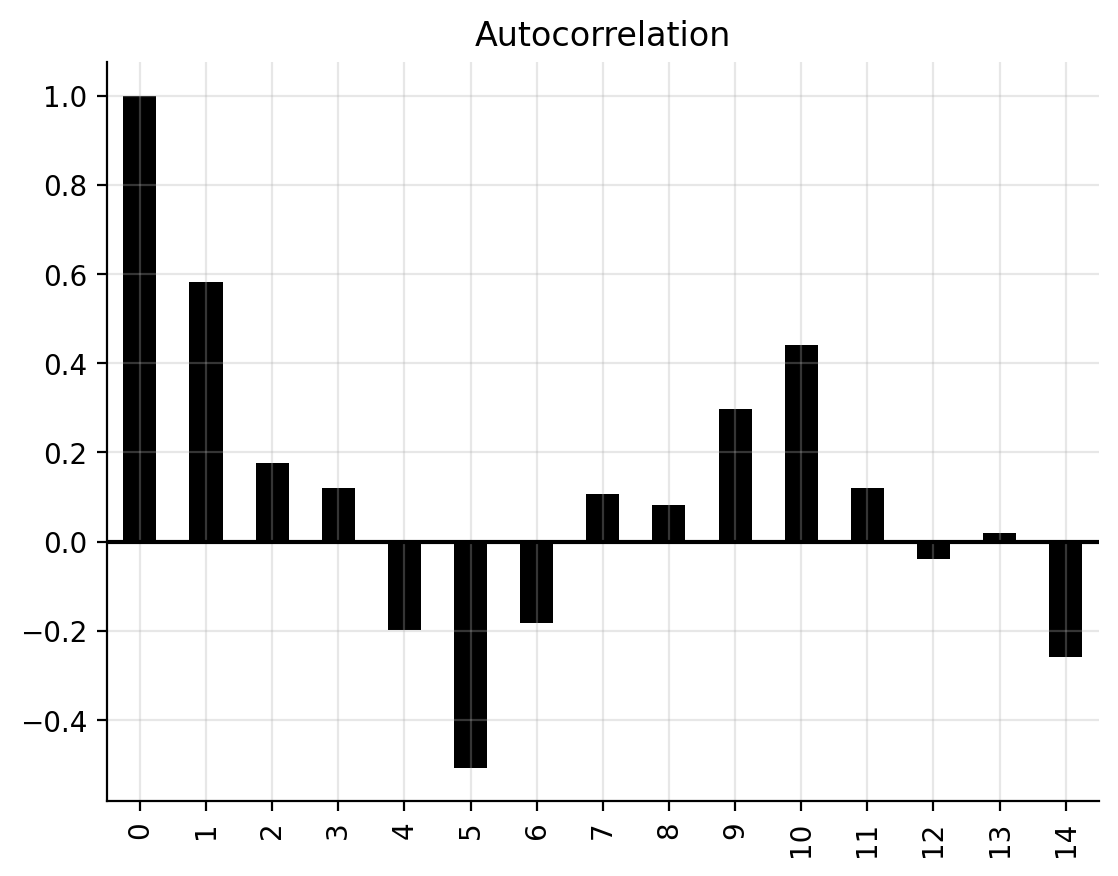

In [26]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 15):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.axhline(y=0, c="black")
plt.title("Autocorrelation")
plt.grid(alpha=0.3)

## BLUP

In [44]:
step_arma = partial(step, F=Farma, H=Harma, T=Trm)

In [45]:
def ssm(key, signal_init, n_steps):
    keys = jax.random.split(key, n_samples)
    _, hist = jax.lax.scan(step_arma, z0, keys)
    hist = jax.tree.map(jnp.squeeze, hist)
    return hist

In [46]:
z0 = jnp.zeros((r + m,1))
hist = ssm(key, z0, n_samples)

In [51]:
hist["z"].shape

(100, 9)

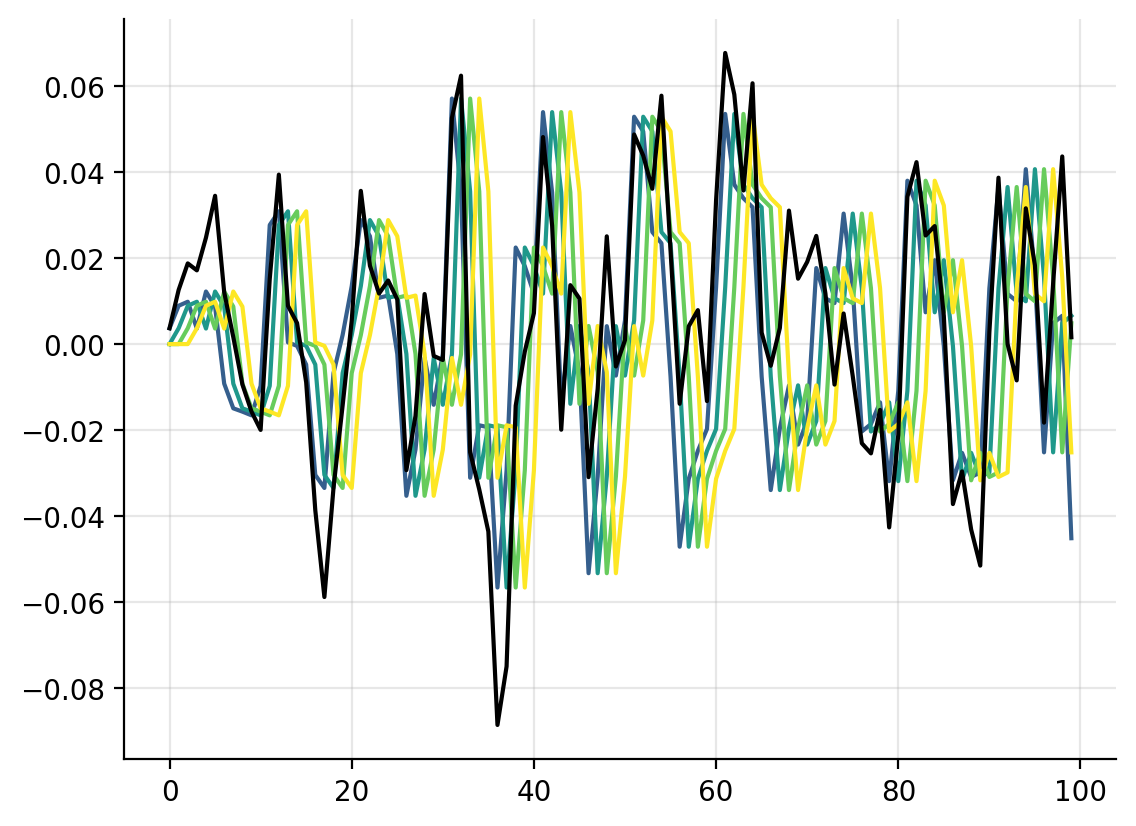

In [49]:
colors = plt.cm.viridis(jnp.linspace(0.3, 1, r))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.plot(hist["y"], c="black")
plt.grid(alpha=0.3)